In [1]:
%load_ext autoreload

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv("../.env")

True

In [2]:
%autoreload 2

import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import tqdm
from numpy.linalg import norm
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    precision_recall_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_class_weight

from estuary.util.img import false_color

In [3]:
def parse_dt_from_asset_id(asset_id: str) -> datetime.datetime:
    """Parse acquisition datetime from file stem prefix YYYYMMDD_HHMMSS_*"""
    datetime_str = "_".join(asset_id.split("_")[:2])
    date_format = "%Y%m%d_%H%M%S"
    return datetime.datetime.strptime(datetime_str, date_format)

In [4]:
skipped_grids = pd.read_csv("/Volumes/x10pro/estuary/geos/skipped_regions.csv")[
    "Site code"
].tolist()
print(skipped_grids)

[13, 24, 30, 36, 42, 47, 49, 60, 61, 69, 71, 74, 75, 76, 78, 80, 82, 89, 90, 91, 231]


In [5]:
stats_df = pd.read_parquet("/Volumes/x10pro/estuary/ca_all/data_stats.parquet")
stats_df.head()

,acquired,anomalous_pixels,clear_confidence_percent,clear_percent,cloud_cover,cloud_percent,ground_control,gsd,heavy_haze_percent,instrument,...,tif_std_4,p90_vis,p95_vis,bright_frac,low_tex_frac,nir_ratio,mean_brightness,std_texture,lap_var,spec_consistency
0,2017-05-28T17:43:42.631067Z,0.01,86,100,0.00,0,True,4.0,0,PS2,...,870.924683,1640.666626,1883.666626,0.173438,0.036776,2.170949,801.128296,462.565430,4386.635254,0.992294
1,2017-05-27T17:44:13.202718Z,0.05,64,33,0.56,56,True,4.0,0,PS2,...,909.661804,1996.333374,2218.000000,0.180670,0.026813,1.865665,1090.065796,527.910950,7195.332031,0.988543
2,2017-05-13T17:49:24.2877Z,0.02,83,87,0.07,7,True,3.9,0,PS2,...,902.330200,1808.000000,2069.750061,0.180271,0.244672,1.859764,838.523499,550.480164,5128.672852,0.990755
3,2017-06-29T17:45:31.682234Z,0.01,97,100,0.00,0,True,3.9,0,PS2,...,814.969421,1888.000000,2260.000000,0.167017,0.186291,1.541564,1033.346313,524.623718,8285.262695,0.987714
4,2017-06-28T17:45:41.323644Z,0.01,94,100,0.00,0,True,3.9,0,PS2,...,766.441589,1710.333374,2022.000000,0.164540,0.177220,1.694341,857.642639,521.602844,7629.768066,0.989797


In [6]:
stats_df["cloud_haze_percent"] = stats_df["cloud_percent"] + stats_df["heavy_haze_percent"]
stats_df["udm_cloud_haze"] = stats_df["udm_mean_5"] + stats_df["udm_mean_6"]

scene_columns = [
    "p90_vis",
    "p95_vis",
    "bright_frac",
    "low_tex_frac",
    "nir_ratio",
    "mean_brightness",
    "std_texture",
    "lap_var",
    "spec_consistency",
    "udm_mean_1",
    "udm_mean_4",
    "udm_cloud_haze",
]
columns = [
    "p90_vis",
    "p95_vis",
    "bright_frac",
    "low_tex_frac",
    "nir_ratio",
    "mean_brightness",
    "std_texture",
    "lap_var",
    "spec_consistency",
]
for i in range(1, 5):
    columns.append(f"tif_std_{i}")
    columns.append(f"tif_mean_{i}")

X = stats_df[columns]

In [7]:
img_stats_scaler = StandardScaler()
X_scaled = img_stats_scaler.fit_transform(X)

In [17]:
db = DBSCAN(eps=0.7, min_samples=20, n_jobs=-1).fit(X_scaled)
stats_df["dbscan_cluster"] = db.labels_

In [18]:
stats_df.groupby("dbscan_cluster").mean_brightness.size()

dbscan_cluster
-1     58553
 0     29477
 1        93
 2        25
 3         9
 4        16
 5        16
 6        17
 7        36
 8        14
 9        25
 10       31
 11       16
 12       27
 13       37
 14       18
 15       20
 16       21
 17       20
 18       21
 19       12
 20       48
 21       44
 22       33
 23       18
Name: mean_brightness, dtype: int64

In [19]:
stats_df.groupby("dbscan_cluster")[scene_columns].mean()

,p90_vis,p95_vis,bright_frac,low_tex_frac,nir_ratio,mean_brightness,std_texture,lap_var,spec_consistency,udm_mean_1,udm_mean_4,udm_cloud_haze
dbscan_cluster,,,,,,,,,,,,
-1,1798.934042,2228.600404,0.133883,0.145324,1.838909,1040.999051,567.735419,7567.964020,0.968408,0.866302,0.082949,0.028501
0,1543.334441,1845.163422,0.146095,0.160232,1.769137,817.669455,502.551507,6812.953093,0.979414,0.984786,0.009751,0.001435
1,1804.256987,1954.441575,0.143583,0.006901,1.296373,1454.717972,256.034736,2754.723416,0.984233,0.303244,0.571690,0.121867
2,1320.622670,1564.164672,0.152087,0.203868,2.800192,689.259976,411.379972,9247.903643,0.988052,0.999326,0.000000,0.000000
3,868.037035,1304.587040,0.063245,0.018169,2.523696,561.344025,501.975115,5808.993571,0.988355,0.990575,0.001461,0.006409
4,1557.941652,1714.304173,0.138123,0.004655,1.292617,1209.224220,254.686999,3139.092270,0.983986,0.245531,0.690345,0.058160
5,2228.881264,3133.856270,0.128168,0.075166,1.474195,877.157185,895.209431,6615.936783,0.985740,0.944667,0.000174,0.000077
6,1421.778423,1615.384302,0.122974,0.005217,1.461854,1087.760193,269.938815,4193.400498,0.980671,0.636071,0.332664,0.015321
7,2175.807404,2269.449988,0.163857,0.005767,1.166207,1863.609090,217.586012,2202.409202,0.983568,0.230878,0.462346,0.300092


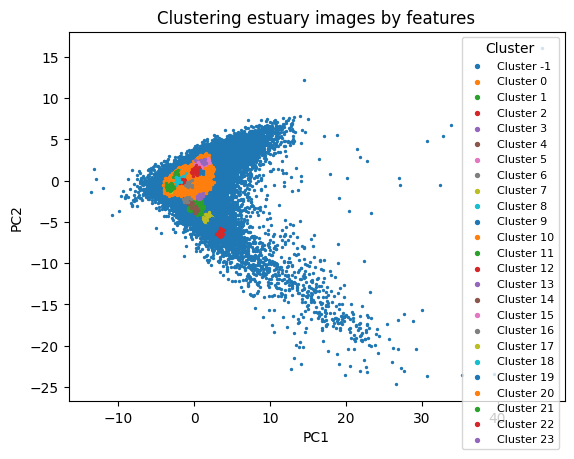

In [20]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

unique_clusters = np.unique(stats_df["dbscan_cluster"])

for cluster in unique_clusters:
    mask = stats_df["dbscan_cluster"] == cluster
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=2, label=f"Cluster {cluster}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clustering estuary images by features")
plt.legend(markerscale=2, fontsize=8, title="Cluster")
plt.show()

In [21]:
def visualize_iter(iii):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))

    for ax in axes.flatten():
        ax.axis("off")
        try:
            row = next(iii)
            source_tif = row.source_tif
            with rasterio.open(source_tif) as src:
                data = src.read()
                nodata = src.read(1, masked=True).mask
                img = false_color(data, nodata)
                ax.imshow(img)
        except:
            continue
    fig.tight_layout()
    plt.show()


def visualize_cluster_iter(i, cluster_key):
    cdf = stats_df[stats_df[cluster_key] == i]
    idxes = list(range(len(cdf)))
    np.random.shuffle(idxes)

    for idx in idxes:
        yield cdf.iloc[idx]

In [23]:
dbscan_iter = visualize_cluster_iter(0, "dbscan_cluster")

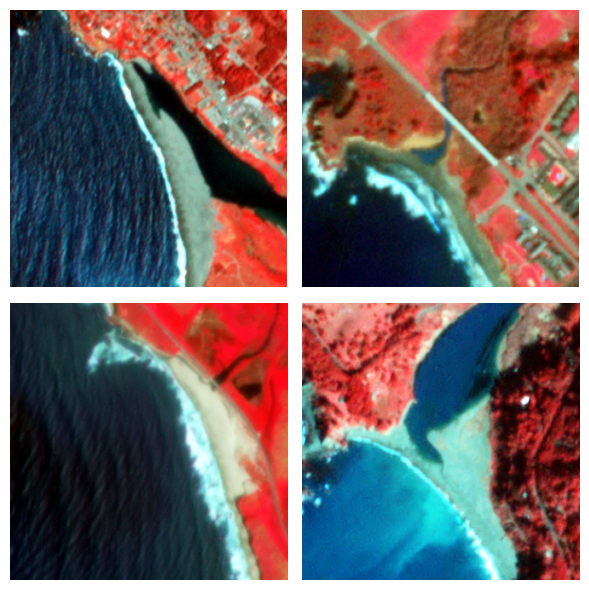

In [42]:
visualize_iter(dbscan_iter)

In [43]:
stats_df[stats_df.dbscan_cluster == 0].base.value_counts()

base
ca_all         28866
low_quality      611
Name: count, dtype: int64

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.18it/s]


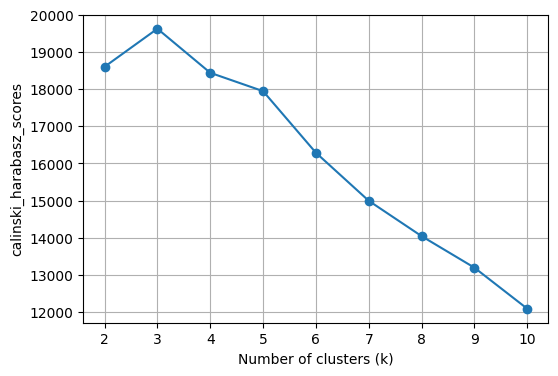

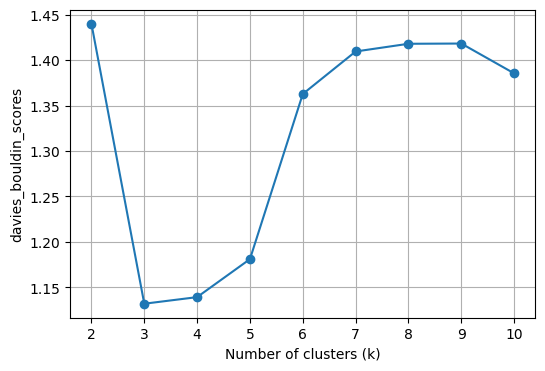

In [44]:
# Try a range of k values
chs = []
dbs = []
K = range(2, 11)

cluster_index = stats_df[stats_df.dbscan_cluster != 0].index
X_scaled_filt = X_scaled[cluster_index]

for k in tqdm.tqdm(list(K)):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(X_scaled_filt)
    labels = km.labels_
    chs.append(calinski_harabasz_score(X_scaled_filt, labels))
    dbs.append(davies_bouldin_score(X_scaled_filt, labels))

# Plot the elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K, chs, "o-")
plt.xlabel("Number of clusters (k)")
plt.ylabel("calinski_harabasz_scores")
plt.grid(True)
plt.show()

# Plot the elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K, dbs, "o-")
plt.xlabel("Number of clusters (k)")
plt.ylabel("davies_bouldin_scores")
plt.grid(True)
plt.show()

In [119]:
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X_scaled_filt)
stats_df["cluster"] = -1
index = stats_df[stats_df.dbscan_cluster != 0].index
stats_df.loc[index, "cluster"] = labels

In [120]:
stats_df.cluster.value_counts()

cluster
-1    29477
 1    22804
 3    21367
 2     7755
 0     6658
 4      586
Name: count, dtype: int64

In [121]:
stats_df.groupby("cluster")[scene_columns].mean()

,p90_vis,p95_vis,bright_frac,low_tex_frac,nir_ratio,mean_brightness,std_texture,lap_var,spec_consistency,udm_mean_1,udm_mean_4,udm_cloud_haze
cluster,,,,,,,,,,,,
-1,1543.334441,1845.163422,0.146095,0.160232,1.769137,817.669455,502.551507,6812.953093,0.979414,0.984786,0.009751,0.001435
0,3243.980696,4054.609422,0.156531,0.153319,1.347969,1339.108683,1167.288474,12982.096109,0.989037,0.887833,0.025756,0.009347
1,1075.107956,1338.989900,0.117249,0.137578,2.373464,667.796409,363.865781,4717.031824,0.957586,0.942389,0.043970,0.003779
2,2133.775483,2311.401752,0.145755,0.100485,1.309421,1716.193334,314.526354,3538.048451,0.957320,0.430073,0.397425,0.163844
3,1892.133232,2476.701877,0.140115,0.168928,1.630654,987.668984,693.555268,9680.734862,0.980482,0.946713,0.030154,0.006417
4,5490.285778,5554.635436,0.148371,0.032473,1.092504,5197.904202,277.192998,30012.444155,0.871866,0.335522,0.125511,0.293561


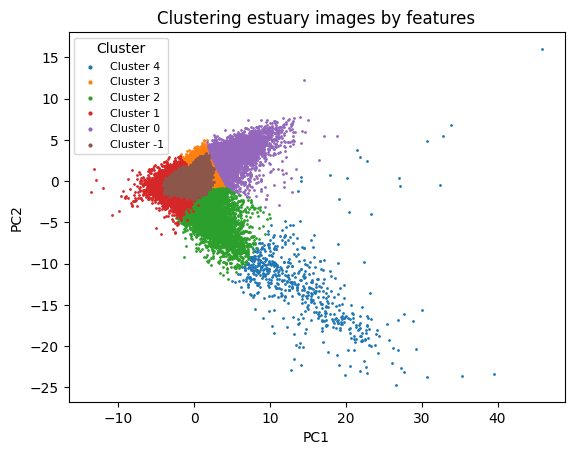

In [122]:
pca = PCA(n_components=2)

plt_X = stats_df

X_pca = pca.fit_transform(X_scaled)

unique_clusters = np.unique(plt_X["cluster"])
unique_clusters = unique_clusters[np.argsort(-1 * unique_clusters)]

for cluster in unique_clusters:
    mask = plt_X["cluster"] == cluster
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=1, label=f"Cluster {cluster}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clustering estuary images by features")
plt.legend(markerscale=2, fontsize=8, title="Cluster")
plt.show()

In [150]:
stats_df.groupby("cluster").base.value_counts()

cluster  base       
-1       ca_all         28866
         low_quality      611
 0       ca_all          6263
         low_quality      395
 1       ca_all         21031
         low_quality     1773
 2       low_quality     5113
         ca_all          2642
 3       ca_all         19924
         low_quality     1443
 4       low_quality      329
         ca_all           257
Name: count, dtype: int64

In [123]:
kmeans_iter0 = visualize_cluster_iter(0, "cluster")
kmeans_iter1 = visualize_cluster_iter(1, "cluster")
kmeans_iter2 = visualize_cluster_iter(2, "cluster")
kmeans_iter3 = visualize_cluster_iter(3, "cluster")
kmeans_iter4 = visualize_cluster_iter(4, "cluster")

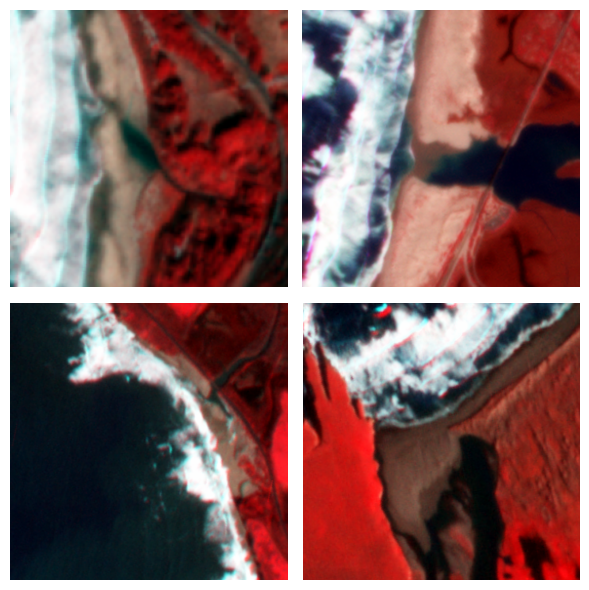

In [622]:
visualize_iter(kmeans_iter0)

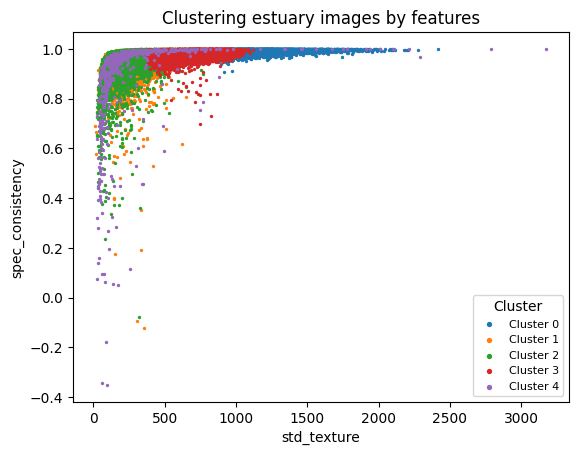

In [151]:
unique_clusters = np.unique(stats_df["cluster"])

for cluster in unique_clusters:
    if cluster == -1:
        continue
    mask = stats_df[stats_df["cluster"] == cluster]
    plt.scatter(x=mask["std_texture"], y=mask["spec_consistency"], s=2, label=f"Cluster {cluster}")

plt.xlabel("std_texture")
plt.ylabel("spec_consistency")
plt.title("Clustering estuary images by features")
plt.legend(markerscale=2, fontsize=8, title="Cluster")
plt.show()

<Axes: >

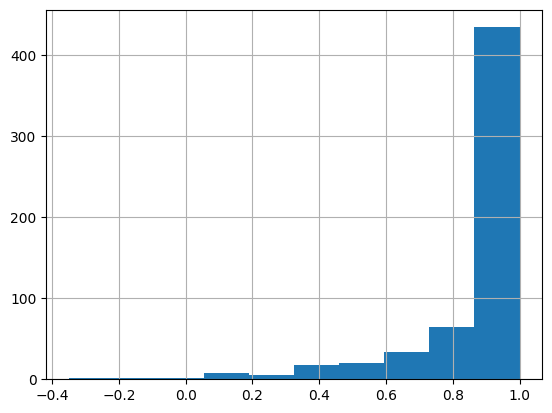

In [152]:
stats_df[stats_df["cluster"] == 4].spec_consistency.hist()

In [623]:
def bbb():
    filt = stats_df[(stats_df["cluster"] == 4)]
    filt_idx = list(range(len(filt)))
    np.random.shuffle(filt_idx)
    for i in filt_idx:
        yield filt.iloc[i]


a = bbb()

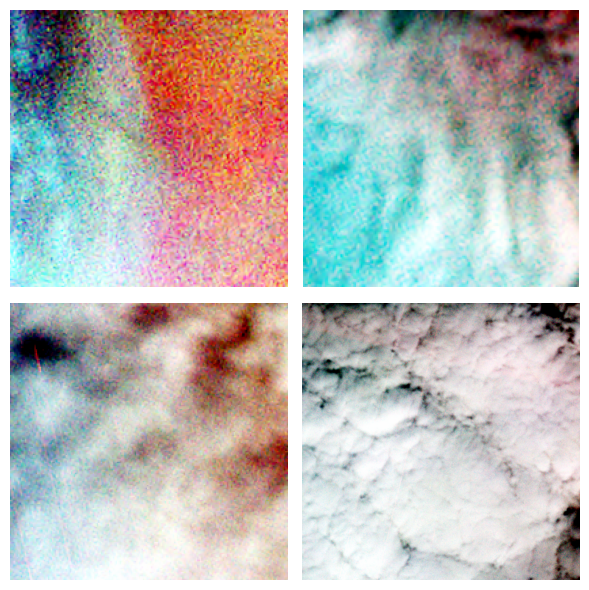

In [644]:
visualize_iter(a)

In [169]:
# 0) Load manifest + embeddings
def load_emb(tif_path):
    tif_path = Path(tif_path)
    region = tif_path.parents[1].name
    p = Path("/Volumes/x10pro/estuary/clay_embeddings/") / region / f"{tif_path.stem}.npy"
    e = np.load(p)
    return e.astype(np.float32)


stats_df["emb"] = stats_df["source_tif"].apply(load_emb)
E = np.vstack(stats_df["emb"].values)  # shape (N, D)

In [646]:
# stats_df["cluster_label"] = -1
# stats_df.loc[stats_df["dbscan_cluster"] == 0, "cluster_label"] = 0
# stats_df.loc[stats_df["cluster"] == 0, "cluster_label"] = 0
# stats_df.loc[(stats_df["cluster"] == 4), "cluster_label"] = 1
# LABELS = {"unlabeled": -1, "high_quality": 0, "cloudy": 1}

In [3486]:
# 1) Seed labels from clusters
seed = stats_df["cluster_label"]
seed_mask = seed.isin([0, 1])
y_seed = seed[seed_mask].values
E_seed = E[seed_mask]

In [3487]:
# 2) Scale and fit a simple classifier (precision > recall bias)
clay_scaler = StandardScaler()
E_seed_z = clay_scaler.fit_transform(E_seed)


def create_emb_dataset(X_all, y_all):
    # X_all: (N, D) embeddings, y_all: 0=good, 1=cloud
    N_pos = (y_all == 1).sum() + (y_all == 2).sum()
    N_neg = (y_all == 0).sum()

    # 1) Subsample negatives (e.g., 10x positives)
    neg_keep = min(10 * N_pos, N_neg)
    neg_idx = np.flatnonzero(y_all == 0)
    pos_idx = np.flatnonzero(y_all > 0)
    rng = np.random.default_rng(42)
    neg_sub = rng.choice(neg_idx, size=neg_keep, replace=False)
    keep = np.r_[pos_idx, neg_sub]

    X = X_all[keep]
    y = y_all[keep]

    # 2) Split with stratification
    Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

    # 3) Weights that reflect ORIGINAL prevalence (not the subsampled set)
    classes = np.array([0, 1])
    class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_all)
    w_map = {c: w for c, w in zip(classes, class_weights, strict=False)}
    wtr = np.array([w_map[yi] for yi in ytr])

    return Xtr, Xva, ytr, yva, wtr


Xtr, Xva, ytr, yva, wtr = create_emb_dataset(E_seed_z, y_seed)

# 4) Train (L2 is fine; try C in {0.1, 1, 3})
clf = LogisticRegression(
    solver="lbfgs",
    max_iter=2000,
    C=0.1,
    n_jobs=None,  # no need for saga/l1 on dense embeddings
)
clf.fit(Xtr, ytr, sample_weight=wtr)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [3488]:
# 4) Apply to everyone
E_all_z = clay_scaler.transform(E)
stats_df["p_cloud_emb"] = clf.predict_proba(E_all_z)[:, 1]
stats_df["p_good_emb"] = clf.predict_proba(E_all_z)[:, 0]

In [3489]:
thresholds = {}
proba_va = clf.predict_proba(Xva)  # shape (N, 3)

for key, value in LABELS.items():
    if value < 0:
        continue

    # One-vs-rest for cloudy
    yva_label = (yva == value).astype(int)
    pva_label = proba_va[:, value]

    prec, rec, thr = precision_recall_curve(yva_label, pva_label)
    ap = average_precision_score(yva_label, pva_label)

    print(key, value)

    target_prec = 0.98
    ok = np.where(prec >= target_prec)[0]
    if len(ok):
        thr_label = thr[ok[0]]
    else:
        # fallback: take threshold that maximizes precision*recall, or a high quantile
        print("No hits, alternative path for", key)
        f = prec * rec
        thr_label = thr[np.argmax(f)] if len(thr) else 0.5

    thresholds[value] = thr_label

    print(f"[{key}] AP={ap:.3f}, threshold={thr_label:.3f} for ≥{target_prec:.0%} precision")

high_quality 0
[high_quality] AP=1.000, threshold=0.000 for ≥98% precision
cloudy 1
[cloudy] AP=1.000, threshold=0.018 for ≥98% precision


In [3490]:
def l2_normalize(E, eps=1e-8):
    n = norm(E, axis=1, keepdims=True)
    return E / (n + eps)


def trimmed_region_proto(E_reg, trim=0.2, iters=2):
    """
    Robust per-region prototype: iteratively drop the lowest-cosine tail and recompute.
    E_reg: (n_r, d) normalized embeddings for a single region.
    """
    keep = np.arange(E_reg.shape[0])
    for _ in range(iters):
        proto = E_reg[keep].mean(axis=0)
        proto /= norm(proto) + 1e-8
        cos = E_reg @ proto
        k = max(1, int(np.ceil((1 - trim) * len(keep))))
        keep = keep[np.argpartition(cos[keep], -k)[-k:]]
    proto = E_reg[keep].mean(axis=0)
    return proto / (norm(proto) + 1e-8)


def per_region_cosine(stats_df, E_norm, good_mask):
    """
    Compute cosine-to-region-proto for rows in stats_df[good_mask].
    Returns:
        cos_to_region: np.ndarray (N,) aligned to stats_df.index
        region_protos: dict[region] -> np.ndarray(d,)
    """
    cos_to_region = np.full(len(stats_df), np.nan, dtype=np.float32)
    region_protos = {}
    for region, idx in stats_df[good_mask].groupby("region").apply(lambda x: x.index).items():
        idx = np.array(idx, dtype=int)
        E_reg = E_norm[idx]
        proto = trimmed_region_proto(E_reg, trim=0.2, iters=2)
        region_protos[region] = proto

    for region, rows in stats_df.groupby("region"):
        idx = np.array(rows.index)
        E_reg = E_norm[idx]
        proto = region_protos[region]
        cos_to_region[idx] = E_reg @ proto  # embeddings are normalized → cosine = dot

    return cos_to_region, region_protos


def global_label_proto(E_norm, global_idx):
    E_reg = E_norm[global_idx]
    proto = trimmed_region_proto(E_reg, trim=0.1, iters=2)
    return proto / (norm(proto) + 1e-8)

In [3491]:
# normalize once for fast cosine
E_norm = l2_normalize(E)
good_mask = stats_df["cluster_label"] == 0
cloud_mask = stats_df["cluster_label"] == 1
# per-region cosine to robust region prototype
cos_region, region_protos = per_region_cosine(stats_df, E_norm, good_mask)
stats_df["cos_region"] = cos_region

/var/folders/pr/1dt1qk511zdgzhfy1xskpqm00000gn/T/ipykernel_50832/3904645191.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  for region, idx in stats_df[good_mask].groupby("region").apply(lambda x: x.index).items():


In [3492]:
# global cloud prototype + cosine
cloud_idx = np.flatnonzero(cloud_mask.values)
cloud_proto = global_label_proto(E_norm, cloud_idx)
stats_df["cos_cloud"] = E_norm @ cloud_proto

In [3493]:
# pick per-region cutoffs via robust quantiles
region_cuts = (
    stats_df[good_mask]
    .groupby("region")["cos_region"]
    .quantile(0.01)  # keep 95% most typical; review the bottom 5%
    .to_dict()
)


def is_region_outlier(row):
    cut = region_cuts.get(row["region"], None)
    return (cut is not None) and (row["cos_region"] < cut)


good_rows = stats_df[good_mask].copy()
good_rows["region_outlier"] = good_rows.apply(is_region_outlier, axis=1)

# combine signals – tune weights; threshold was from your PR-curve calibration
alpha, beta, gamma = 0.5, 0.3, 0.1  # (LR prob, cloud cosine, region deviation)
good_rows["good_score_combo"] = (
    alpha * good_rows["p_cloud_emb"]
    + beta * good_rows["cos_cloud"]
    + gamma
    * (
        1.0
        - np.clip(
            (good_rows["cos_region"] - region_cuts.get(good_rows["region"].iloc[0], -1)) / 1.0, 0, 1
        )
    )
)
cloud_cos_thresh = np.quantile(stats_df.loc[cloud_mask, "cos_cloud"], 0.25)

# candidates to remove from GOOD:
to_review_good = good_rows[
    # good_rows["region_outlier"] |
    # (~good_rows["region_outlier"]) &
    (
        good_rows["p_cloud_emb"] >= thresholds[1]
        # | (good_rows["cos_cloud"] >= cloud_cos_thresh)
    )
].copy()

print("to_review_good", len(to_review_good))

# final cleaned good set
good_clean_idx = good_rows.index.difference(to_review_good.index)
good_clean = stats_df.loc[good_clean_idx]

to_review_good 49


In [3494]:
def good_review_iter():
    for region, rt in to_review_good.groupby("region"):
        rt = rt.sort_values("good_score_combo", ascending=False)
        print(region, len(rt))
        yield region, rt


a = good_review_iter()

In [3517]:
_, rt = next(a)


def rt_rt(rt):
    for _, a in rt.iterrows():
        yield a


region_iter = rt_rt(rt)

54 1


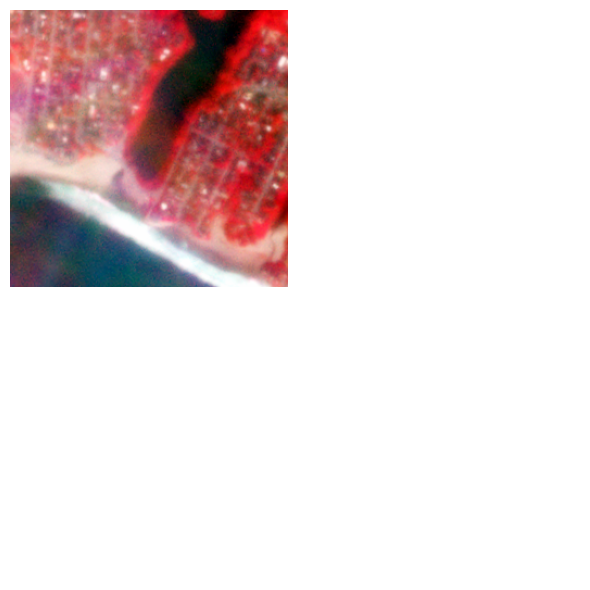

In [3518]:
visualize_iter(region_iter)

In [2574]:
# stats_df.loc[to_review_good.index, "cluster_label"] = -1

In [3524]:
# pick per-region cutoffs via robust quantiles
region_cuts = stats_df[good_mask].groupby("region")["cos_region"].quantile(0.001).to_dict()


def is_region_inlier(row):
    cut = region_cuts.get(row["region"], None)
    return (cut is not None) and (row["cos_region"] > cut)


search_pool = stats_df[cloud_mask].copy()
search_pool["region_inlier"] = search_pool.apply(is_region_inlier, axis=1)

cloud_cos_thresh = search_pool["cos_cloud"].quantile(0.01)

alpha, beta, gamma = 0.5, 0.4, 0.1  # (LR prob, cloud cosine, region deviation)
search_pool["cloud_score_combo"] = (
    alpha * search_pool["p_cloud_emb"]
    + beta * search_pool["cos_cloud"]
    + gamma * (1.0 - (search_pool["cos_region"].fillna(search_pool["cos_region"].median())))
)
all_cloud_remove_candidates = search_pool[
    (search_pool.region_inlier) | (search_pool.p_cloud_emb < 0.05)  # |
    # (search_pool.cos_cloud < cloud_cos_thresh) #|
]
print("all_cloud_remove_candidates", len(all_cloud_remove_candidates))


def rt_rt(rt):
    idx = list(range(len(rt)))
    np.random.shuffle(idx)
    for i in idx:
        yield rt.iloc[i]


cloud_remove_iter = rt_rt(all_cloud_remove_candidates)

all_cloud_remove_candidates 1


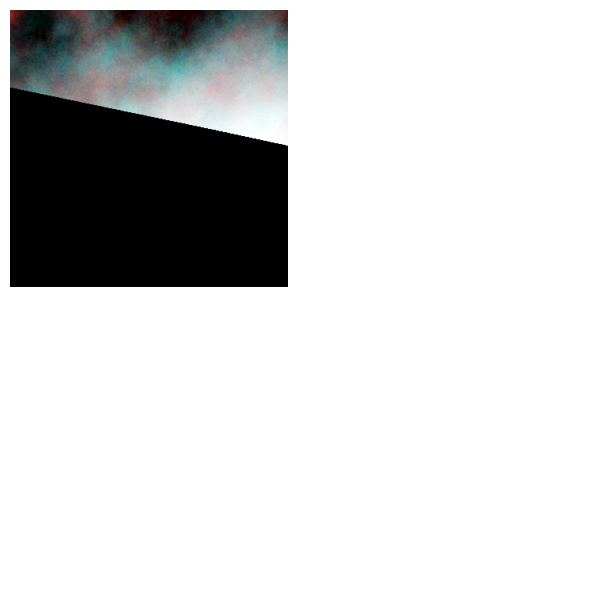

In [3525]:
visualize_iter(cloud_remove_iter)

In [3526]:
stats_df.loc[all_cloud_remove_candidates.index, "cluster_label"] = -1

In [3527]:
# pick per-region cutoffs via robust quantiles
region_cuts = stats_df[good_mask].groupby("region")["cos_region"].quantile(0.01).to_dict()


def is_region_inlier(row):
    cut = region_cuts.get(row["region"], None)
    return (cut is not None) and (row["cos_region"] > cut)


search_pool = stats_df[stats_df.cluster_label == -1].copy()
search_pool["is_region_inlier"] = search_pool.apply(is_region_inlier, axis=1)

cloud_cos_thresh = stats_df[cloud_mask]["cos_cloud"].quantile(0.9)

alpha, beta, gamma = 0.5, 0.4, 0.1  # (LR prob, cloud cosine, region deviation)
search_pool["cloud_score_combo"] = (
    alpha * search_pool["p_cloud_emb"]
    + beta * search_pool["cos_cloud"]
    + gamma * (1.0 - (search_pool["cos_region"].fillna(search_pool["cos_region"].median())))
)
all_cloud_candidates = search_pool[
    (~search_pool.is_region_inlier)
    & (
        search_pool.p_cloud_emb > 0.5  # |
        # (search_pool.cos_cloud > cloud_cos_thresh)
    )
]
print("all_cloud_candidates", len(all_cloud_candidates))

# take top-K per region for review
K = 8
cloud_candidates = (
    all_cloud_candidates.sort_values("cloud_score_combo", ascending=False)
    .groupby("region", group_keys=False)
    .head(K)
)


def cloud_iter():
    for region, ci in cloud_candidates.groupby("region"):
        print(region, len(ci))
        yield ci


b = cloud_iter()

all_cloud_candidates 14


In [3528]:
rt = next(b)


def rt_rt(rt):
    idx = list(range(len(rt)))
    np.random.shuffle(idx)
    for i in idx:
        yield rt.iloc[i]


region_cloud_iter = rt_rt(all_cloud_candidates)

11 1


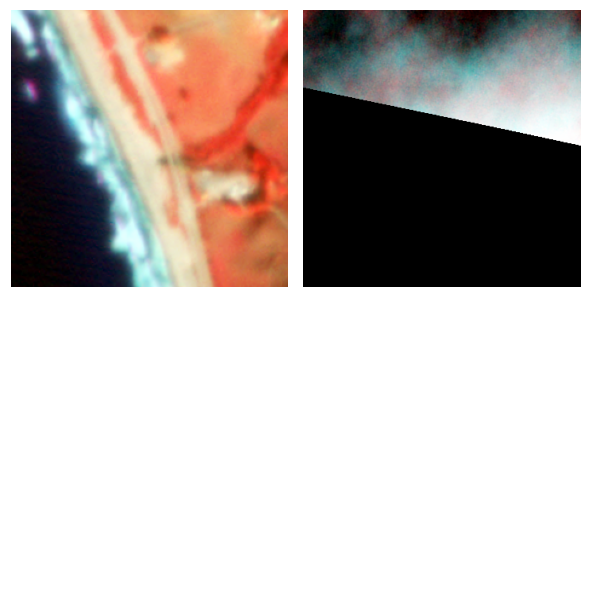

In [3532]:
visualize_iter(region_cloud_iter)

In [2781]:
stats_df.loc[all_cloud_candidates.index, "cluster_label"] = 1

In [3533]:
# pick per-region cutoffs via robust quantiles
region_cuts = stats_df[good_mask].groupby("region")["cos_region"].quantile(0.35).to_dict()


def is_region_inlier(row):
    cut = region_cuts.get(row["region"], None)
    return (cut is not None) and (row["cos_region"] > cut)


search_pool = stats_df[stats_df.cluster_label == -1].copy()
search_pool["region_inlier"] = search_pool.apply(is_region_inlier, axis=1)

all_good_add_candidates = search_pool[
    (search_pool.region_inlier) & (search_pool.p_cloud_emb < 0.01)
]
print("all_good_add_candidates", len(all_good_add_candidates))

# take top-K per region for review
K = 8
good_add_candidates = (
    all_good_add_candidates.sort_values("cos_region", ascending=False)
    .groupby("region", group_keys=False)
    .head(K)
)


def region_iter():
    for region, ci in good_add_candidates.groupby("region"):
        print(region, len(ci))
        yield ci


b = region_iter()

all_good_add_candidates 718


In [3534]:
rt = next(b)
region_iter_iter = rt_rt(good_add_candidates)

11 8


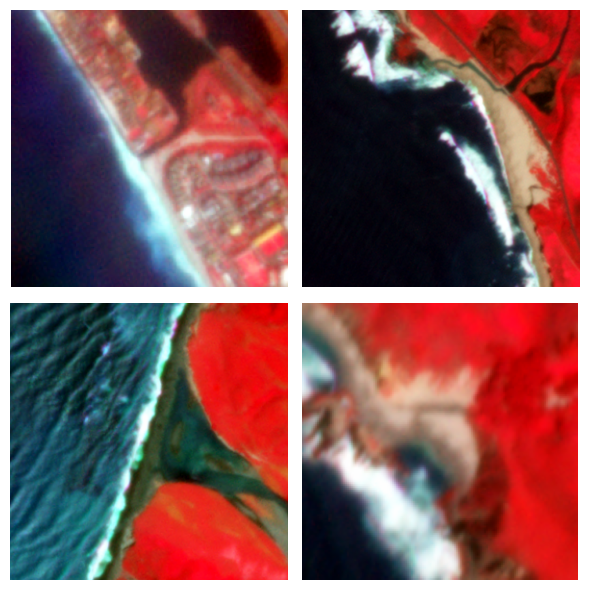

In [3554]:
visualize_iter(region_iter_iter)

In [3555]:
stats_df.loc[good_add_candidates.index, "cluster_label"] = 0

In [3556]:
stats_df.columns

Index(['acquired', 'anomalous_pixels', 'clear_confidence_percent',
       'clear_percent', 'cloud_cover', 'cloud_percent', 'ground_control',
       'gsd', 'heavy_haze_percent', 'instrument', 'item_type',
       'light_haze_percent', 'pixel_resolution', 'provider', 'published',
       'publishing_stage', 'quality_category', 'satellite_azimuth',
       'satellite_id', 'shadow_percent', 'snow_ice_percent', 'strip_id',
       'sun_azimuth', 'sun_elevation', 'updated', 'view_angle',
       'visible_confidence_percent', 'visible_percent', 'asset_id', 'year',
       'dove', 'month', 'region', 'base', 'source_tif', 'source_udm',
       'udm_mean_1', 'udm_mean_2', 'udm_mean_3', 'udm_mean_4', 'udm_mean_5',
       'udm_mean_6', 'udm_mean_7', 'tif_mean_1', 'tif_mean_2', 'tif_mean_3',
       'tif_mean_4', 'tif_std_1', 'tif_std_2', 'tif_std_3', 'tif_std_4',
       'p90_vis', 'p95_vis', 'bright_frac', 'low_tex_frac', 'nir_ratio',
       'mean_brightness', 'std_texture', 'lap_var', 'spec_consistency',

In [3557]:
stats_df.drop(
    columns=[
        "udm_mean_1",
        "udm_mean_2",
        "udm_mean_3",
        "udm_mean_4",
        "udm_mean_5",
        "udm_mean_6",
        "udm_mean_7",
        "tif_mean_1",
        "tif_mean_2",
        "tif_mean_3",
        "tif_mean_4",
        "tif_std_1",
        "tif_std_2",
        "tif_std_3",
        "tif_std_4",
        "p90_vis",
        "p95_vis",
        "bright_frac",
        "low_tex_frac",
        "nir_ratio",
        "mean_brightness",
        "std_texture",
        "lap_var",
        "spec_consistency",
        "cloud_haze_percent",
        "udm_cloud_haze",
        "dbscan_cluster",
        "cluster",
        "emb",
        "p_cloud_emb",
        "p_noise_emb",
        "cos_region",
        "cos_cloud",
        "cos_noise",
        "p_good_emb",
    ]
).to_csv("/Volumes/x10pro/estuary/low_quality/quality_labels.csv")

In [3558]:
stats_df.groupby(["cluster_label"])["base"].value_counts()

cluster_label  base       
-2             low_quality     2811
               ca_all           832
-1             ca_all         29009
               low_quality     4435
 0             ca_all         48845
               low_quality     1784
 1             low_quality      634
               ca_all           297
Name: count, dtype: int64

In [3559]:
stats_df[stats_df.cluster_label == 1].groupby(["region"]).size().min()

2

In [3560]:
stats_df[stats_df.cluster_label == 0].groupby(["region"]).size().min()

102

<Axes: xlabel='region'>

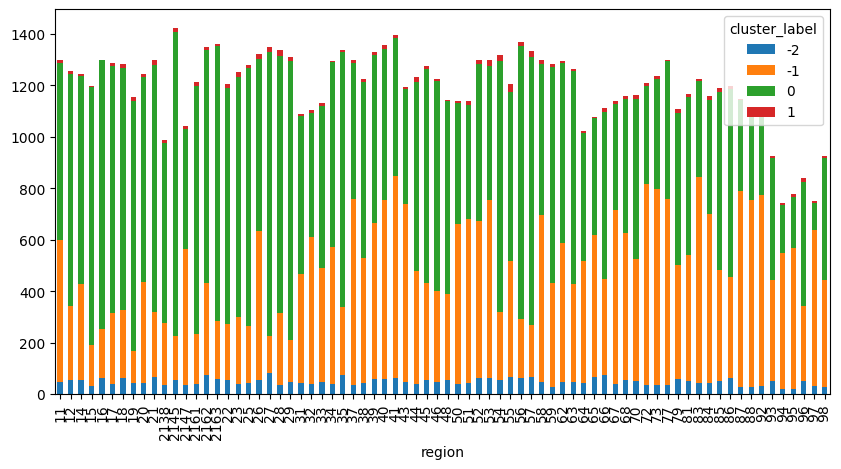

In [3561]:
stats_df.groupby(["region", "cluster_label"]).size().unstack(fill_value=0).plot(
    kind="bar", stacked=True, figsize=(10, 5)
)

In [ ]:
cdf = stats_df[(stats_df.cluster_label == 1)]
cloud_region_cos = {}
to_review = []

for region, gdf in cdf.groupby("region"):
    proto = region_protos[region]
    e = E[gdf.index]
    cos_sim = (e @ proto) / (norm(e, axis=1) + 1e-8)
    cloud_region_cos[region] = cos_sim
    if any(cos_sim > 0.6):
        to_review.append(region)
    stats_df.loc[gdf[cos_sim > 0.6].index, "cluster_label"] = -1

In [ ]:
len(to_review)

In [ ]:
region = to_review[35]
print(region)
jjj = cdf[cdf.region == region][(cloud_region_cos[region] > 0.6)].iterrows()

In [ ]:
plt.hist(cloud_region_cos[region])

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(3 * 4, 3 * 2))

for ax in axes.flatten():
    ax.axis("off")
    try:
        _, row = next(jjj)
    except:
        continue
    with rasterio.open(row.source_tif) as src:
        data = src.read()
        nodata = src.read(1, masked=True).mask
        img = false_color(data, nodata)
    ax.imshow(img)
    ax.set_title(f"CIdx: {row.cluster} DBIdx: {row.dbscan_cluster}")
fig.tight_layout()
plt.show()